modis_2000-2019_Australia.csv is gotten from https://www.kaggle.com/datasets/gabrielbgutierrez/satellite-data-on-australia-fires

In [ ]:
# Simple script to visualize Australian wildfires without crashing
import pandas as pd
import numpy as np
import plotly.express as px

df = pd.read_csv('modis_2000-2019_Australia.csv')

df['acq_date'] = pd.to_datetime(df['acq_date'])
df['year'] = df['acq_date'].dt.year
df = df[df['frp'] >= 0]  
df = df.sort_values('acq_date')

resolution = 0.25  

# Create grid cells
df['grid_lat'] = np.floor(df['latitude'] / resolution) * resolution
df['grid_lon'] = np.floor(df['longitude'] / resolution) * resolution

grid_data = df.groupby(['year', 'grid_lat', 'grid_lon']).agg({
    'frp': ['count', 'sum', 'mean', 'max'],
    'acq_date': 'min'
}).reset_index()

# Fix the column names
grid_data.columns = [
    'year', 'grid_lat', 'grid_lon', 
    'fire_count', 'frp_sum', 'frp_avg', 'frp_max', 
    'first_fire'
]

# Use center of each cell for plotting
grid_data['lat'] = grid_data['grid_lat'] + resolution/2
grid_data['lon'] = grid_data['grid_lon'] + resolution/2

print(f"Reduced to {len(grid_data):,} data points")

# Make the map
years = sorted(grid_data['year'].unique())

fig = px.scatter_geo(
    grid_data,
    lat='lat',
    lon='lon',
    color='frp_sum',  # color by total fire radiative power
    size='fire_count',  # size by number of fires in the cell
    animation_frame='year',
    color_continuous_scale='Inferno',  # fire-like colors
    scope='world',
    projection='natural earth',
    title='Australian Wildfires (2000-2019)',
    hover_data={
        'grid_lat': False,
        'grid_lon': False,
        'lat': ':.2f',
        'lon': ':.2f',
        'fire_count': True,
        'frp_sum': ':.1f',
        'frp_avg': ':.2f',
        'frp_max': ':.1f',
        'first_fire': True
    },
    height=800,
    width=1200
)

# Focus on Australia
fig.update_layout(
    geo=dict(
        lataxis_range=[-45, -10],
        lonaxis_range=[110, 155],
        showland=True,
        landcolor='rgb(217, 217, 217)',
        coastlinecolor='white',
        countrycolor='white',
        showocean=True,
        oceancolor='rgb(204, 229, 255)',
        showcountries=True,
        showsubunits=True,
        subunitcolor='white'
    ),
    font=dict(size=12),
    title_font=dict(size=20),
    margin=dict(l=0, r=0, t=80, b=0),
    coloraxis_colorbar_title='Total FRP'
)

# Make the dots look nice
fig.update_traces(
    marker=dict(
        opacity=0.75,
        line=dict(width=0.5, color='DarkSlateGrey'),
        sizemode='area',
        sizeref=2.*max(grid_data['fire_count'])/(30.**2),
        sizemin=2
    )
)

# Make the animation smoother
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1200
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 600
fig.layout.sliders[0].currentvalue.prefix = 'Year: '

# Show the map
fig.show()

From the above timelapse we can see that Australia has alot of wild fire around espicially 2011 - 2013, we hypothesis that it could drastically affect wild life. 
<br>
We will further explore the burned area in Australia below

In [1]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('modis_2000-2019_Australia.csv')
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['year'] = df['acq_date'].dt.year

annual_area = df.groupby('year').size().reset_index(name='detections')
annual_area['burned_area'] = annual_area['detections'] * 1  

fig = px.line(
    annual_area,
    x='year',
    y='burned_area',
    markers=True,
    title='Annual Burned Area in Australia',
    labels={'burned_area': 'Burned Area (km²)', 'year': 'Year'},
    height=600,
    width=1000
)

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    hovermode='x unified'
)

fig.update_traces(
    line=dict(width=2.5, color='#FF5722'),
    marker=dict(size=8, color='#E64A19')
)

fig.show()

We can see the the burned area is alternating between one year high and one year low, except for the year 2011 and 2012 which could be attributted to harsher winds, lesser rainfall, less humidity which can drastically affect wildlist biodiversity. We will further conduct weather analysis below.

From the line graph below, we can tell that the temperature over the years dont seem to really change drastically telling us that forest fires do not cause a significant increase in temperature across australia. so now we can rule out that biodiversity decrease are not caused by overal temperature in australia


In [14]:
df = pd.read_csv('weatherAUS.csv', parse_dates=['Date'])
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

location_counts = df['Location'].value_counts().reset_index()



yearly_monthly = df.groupby(['Year', 'Month'])[['MinTemp', 'MaxTemp']].mean().reset_index()

fig3 = px.line(yearly_monthly, 
              x='Month', 
              y='MaxTemp',
              color='Year',
              title='<b>Yearly Temperature Trends by Month</b>',
              labels={'MaxTemp': 'Temperature (°C)', 'Month': ''},
              markers=True)

fig3.update_xaxes(
    tickvals=list(range(1,13)),
    ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

fig3.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    args=[{"y": [yearly_monthly['MaxTemp']]}],
                    label="Max Temperature",
                    method="restyle"
                ),
                dict(
                    args=[{"y": [yearly_monthly['MinTemp']]}],
                    label="Min Temperature",
                    method="restyle"
                )
            ],
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ]
)

fig3.update_layout(
    yaxis=dict(
        title="Temperature (°C)",
        showgrid=True
    )
)

fig3.show()



In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import folium
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# Load and preprocess koala data
koalas = pd.read_csv('wildnetkoalalocations.csv', parse_dates=['StartDate'], dayfirst=True)
koalas = koalas[(koalas['StartDate'].dt.year >= 2007) & 
                (koalas['StartDate'].dt.year <= 2016)]
koalas['Year'] = koalas['StartDate'].dt.year
koalas['Month'] = koalas['StartDate'].dt.month

# Load and preprocess weather data
weather = pd.read_csv('weatherAUS.csv', parse_dates=['Date'])
weather = weather[(weather['Date'].dt.year >= 2007) & 
                 (weather['Date'].dt.year <= 2016)]
weather['Year'] = weather['Date'].dt.year
weather['Month'] = weather['Date'].dt.month

weather_station_coords = {
    'Albury': (-36.0748, 146.9240),
    'BadgerysCreek': (-33.8844, 150.7833),
    'Cobar': (-31.4967, 145.8344),
    'CoffsHarbour': (-30.2963, 153.1135),
    'Moree': (-29.4628, 149.8416),
    'Newcastle': (-32.9267, 151.7789),
    'NorahHead': (-33.2815, 151.5680),
    'NorfolkIsland': (-29.0408, 167.9547),
    'Penrith': (-33.7500, 150.7000),
    'Richmond': (-33.6000, 150.7500),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
    'WaggaWagga': (-35.1086, 147.3697),
    'Williamtown': (-32.8064, 151.8436),
    'Wollongong': (-34.4240, 150.8935),
    'Canberra': (-35.2809, 149.1300),
    'Tuggeranong': (-35.4244, 149.0888),
    'MountGinini': (-35.5299, 148.7726),
    'Ballarat': (-37.5622, 143.8503),
    'Bendigo': (-36.7578, 144.2784),
    'Sale': (-38.1040, 147.0675),
    'MelbourneAirport': (-37.6690, 144.8410),
    'Melbourne': (-37.8136, 144.9631),
    'Mildura': (-34.2066, 142.1350),
    'Nhil': (-36.3333, 141.6500),
    'Portland': (-38.3333, 141.6000),
    'Watsonia': (-37.7167, 145.0833),
    'Dartmoor': (-37.9167, 141.2667),
    'Brisbane': (-27.4698, 153.0251),
    'Cairns': (-16.9203, 145.7710),
    'GoldCoast': (-28.0167, 153.4000),
    'Townsville': (-19.2590, 146.8169),
    'Adelaide': (-34.9285, 138.6007),
    'MountGambier': (-37.8316, 140.7652),
    'Nuriootpa': (-34.4682, 139.0047),
    'Woomera': (-31.1999, 136.8326),
    'Albany': (-35.0225, 117.8911),
    'Witchcliffe': (-34.0333, 115.1000),
    'PearceRAAF': (-31.6678, 116.0250),
    'PerthAirport': (-31.9403, 115.9669),
    'Perth': (-31.9505, 115.8605),
    'SalmonGums': (-32.9833, 121.6333),
    'Walpole': (-34.9833, 116.7333),
    'Hobart': (-42.8821, 147.3272),
    'Launceston': (-41.4332, 147.1441),
    'AliceSprings': (-23.6980, 133.8807),
    'Darwin': (-12.4634, 130.8456),
    'Katherine': (-14.4652, 132.2635),
    'Uluru': (-25.3444, 131.0369)
}

# Add columns 'Latitude' and 'Longitude' based on 'Location' column
weather['Latitude'] = weather['Location'].map(lambda x: weather_station_coords[x][0])
weather['Longitude'] = weather['Location'].map(lambda x: weather_station_coords[x][1])

def create_geometry(df, lat_col, lon_col):
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col])
    )
    return gdf.set_crs(epsg=4326)

koala_gdf = create_geometry(koalas, 'Latitude', 'Longitude')
weather_gdf = create_geometry(weather.groupby('Location').first().reset_index(), 
                            'Latitude', 'Longitude')

def find_nearest(source_points, target_points):
    tree = BallTree(target_points[['rad_lat', 'rad_lon']].values, leaf_size=15)
    distances, indices = tree.query(source_points[['rad_lat', 'rad_lon']].values)
    return indices.flatten(), distances.flatten()

koala_gdf['rad_lat'] = np.radians(koala_gdf['Latitude'])
koala_gdf['rad_lon'] = np.radians(koala_gdf['Longitude'])
weather_gdf['rad_lat'] = np.radians(weather_gdf['Latitude'])
weather_gdf['rad_lon'] = np.radians(weather_gdf['Longitude'])

indices, distances = find_nearest(koala_gdf, weather_gdf)
koala_gdf['Nearest_Location'] = weather_gdf.iloc[indices]['Location'].values
koala_gdf['Distance_km'] = distances * 6371 

merged = pd.merge(koala_gdf, weather, 
                 left_on=['Nearest_Location', 'Year', 'Month'],
                 right_on=['Location', 'Year', 'Month'],
                 how='left')

# Ensure only numeric columns are included for aggregation
annual_analysis = merged.groupby(['Year', 'Nearest_Location', 'Latitude_y', 'Longitude_y']).agg(
    Koala_Count=('ScientificName', 'count'),
    Avg_MaxTemp=('MaxTemp', 'mean'),
    Total_Rainfall=('Rainfall', 'sum')
).reset_index()

fig1 = px.density_heatmap(
    annual_analysis,
    x='Avg_MaxTemp',
    y='Total_Rainfall',
    z='Koala_Count',
    histfunc='avg',
    title='Koala Sightings Density by Temperature and Rainfall',
    labels={'Avg_MaxTemp': 'Average Max Temperature (°C)', 
            'Total_Rainfall': 'Annual Rainfall (mm)'},
    height=600
)

# Create a DataFrame with yearly averages
yearly_data = annual_analysis.groupby('Year').mean(numeric_only=True).reset_index()

# Create the figure with one trace
# Create the figure with one trace - explicitly name it "Koala Count"
fig2 = px.line(yearly_data, x='Year', y='Koala_Count', 
               title='Annual Koala Sightings vs Temperature Trends',
               labels={"Koala_Count": "Koala Count"},  # Update axis label
               custom_data=["Year"])  # For hover information

# Update the trace name explicitly
fig2.data[0].name = "Koala Count"

# Add the second trace on a secondary y-axis
fig2.add_trace(
    go.Scatter(
        x=yearly_data['Year'],
        y=yearly_data['Avg_MaxTemp'],
        name='Avg Max Temp',
        yaxis="y2"
    )
)

# Update layout to configure the axes
fig2.update_layout(
    yaxis=dict(title='Koala Count'),
    yaxis2=dict(
        title='Temperature (°C)',
        overlaying='y',
        side='right'
    ),
    legend=dict(
        x=0.01, 
        y=0.99,
        title=None  # Remove legend title
    ),
    height=500
)
# IMPROVED MAP CODE - ADJUSTED CIRCLE SIZES
# Create a better scale for circle sizes - using a much larger range
max_count = annual_analysis['Koala_Count'].max()
min_count = annual_analysis['Koala_Count'].min()

# Create a scaling function with a larger min_radius and max_radius
def scale_radius(count, min_val=min_count, max_val=max_count, min_radius=8, max_radius=30):
    # Ensure a minimum size for better visibility
    if count <= min_val:
        return min_radius
    
    # Use square root scaling for better visual representation 
    # (area proportional to count rather than radius proportional to count)
    normalized_count = (count - min_val) / (max_val - min_val)
    scaled = min_radius + (max_radius - min_radius) * np.sqrt(normalized_count)
    return scaled

# Create a new map
base_map = folium.Map(
    location=[-28, 135],  # Center for Australia
    zoom_start=4,         # Zoom level to see all of Australia
    tiles='CartoDB positron'  # Using a cleaner base map for better visibility of circles
)

# Add a title to the map
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Koala Sightings in Australia (2007-2016)</b></h3>
'''
base_map.get_root().html.add_child(folium.Element(title_html))

# Create a feature group for the koala markers
koala_group = folium.FeatureGroup(name="Koala Sightings")

# Add markers with properly scaled sizes
for idx, row in annual_analysis.iterrows():
    radius = scale_radius(row['Koala_Count'])
    
    # Use a color scale based on temperature
    temp_color = '#FF5722' if row['Avg_MaxTemp'] > 30 else '#4CAF50'
    
    folium.CircleMarker(
        location=[row['Latitude_y'], row['Longitude_y']], 
        radius=radius,
        color='black',
        weight=1.5,
        fill=True,
        fill_color=temp_color,
        fill_opacity=0.8,
        popup=f"<strong>{row['Nearest_Location']}</strong><br>Count: {int(row['Koala_Count'])}<br>Avg Temp: {row['Avg_MaxTemp']:.1f}°C<br>Rainfall: {row['Total_Rainfall']:.1f}mm"
    ).add_to(koala_group)

koala_group.add_to(base_map)

# Add layer control
folium.LayerControl().add_to(base_map)

# Add a legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 180px; height: 120px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     padding: 10px;
     border-radius: 6px;">
     <p><b>Koala Sightings</b></p>
     <div style="display: inline-block; height: 15px; width: 15px; border-radius: 50%; 
           background-color: #FF5722; border: 1px solid black;"></div> Hot (>30°C)<br>
     <div style="display: inline-block; height: 15px; width: 15px; border-radius: 50%; 
           background-color: #4CAF50; border: 1px solid black;"></div> Moderate (≤30°C)<br>
     <p><i>Circle size indicates number of koalas</i></p>
</div>
'''
base_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file for better viewing
base_map.save('koala_distribution_map.html')


From the heatmap below, we can see that koala tend to be sighted in areas with higher amount of rainfall and cooler temperature. the dropoff for temperature is aroun 28-29 degree celcius.

In [2]:
# For displaying in Jupyter notebook
fig1.show()

From the line graph below, we can see that temperature and koala count are correlated; when temperature increases, koala count decreases and vice versa. this tells us that koala thrives in cooler temperature

In [3]:
fig2.show()

from the map below, we can see that forests around he east coast tend to be cooler and have higher koala counts (size of circle) whereas the temperature (color) inland is hotter and have lesser koala sightings as a result

In [4]:
base_map

we can tell from the line graph below that as the fire incidents increase, the koala sightings decrease and vice versa. We can tell that the fire incidents are causing koala to perish or lose their habitat, causing their numbers to decline

C:\Users\Joova\AppData\Local\Temp\ipykernel_47628\1732473449.py:31: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Number of koala sightings with nearby fires: 17630
Average distance to nearest fire: 0.02 degrees
Total fire impact on koala sightings: 3784495281.95


NameError: name 'mpl' is not defined

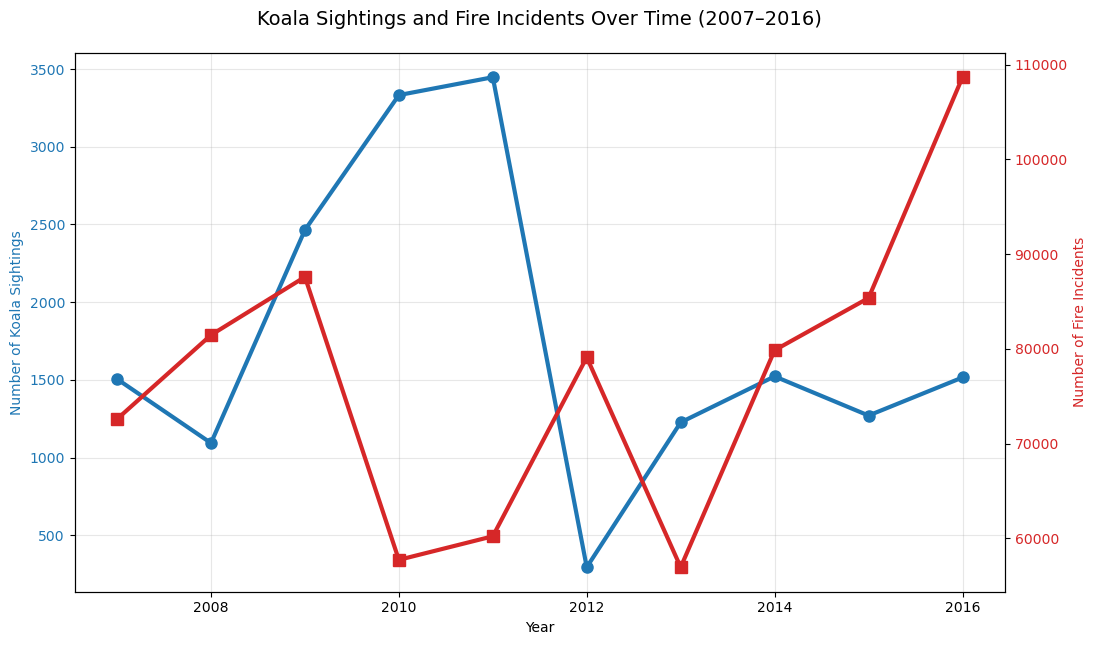

In [6]:
# Koala and Fire Spatial Analysis
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

# Load data
koalas = pd.read_csv("wildnetkoalalocations.csv")
fires = pd.read_csv("modis_2000-2019_Australia.csv")

# Convert dates
koalas["StartDate"] = pd.to_datetime(koalas["StartDate"], format="%d/%m/%Y")
fires["acq_date"] = pd.to_datetime(fires["acq_date"])

# Filter to 2007-2016 time period
koalas = koalas[(koalas["StartDate"].dt.year >= 2007) & (koalas["StartDate"].dt.year <= 2016)]
fires = fires[(fires["acq_date"].dt.year >= 2007) & (fires["acq_date"].dt.year <= 2016)]

# Create geometries
koalas_geometry = [Point(xy) for xy in zip(koalas["Longitude"], koalas["Latitude"])]
fires_geometry = [Point(xy) for xy in zip(fires["longitude"], fires["latitude"])]

# Create GeoDataFrames
koalas_gdf = gpd.GeoDataFrame(koalas, geometry=koalas_geometry, crs="EPSG:4326")
fires_gdf = gpd.GeoDataFrame(fires, geometry=fires_geometry, crs="EPSG:4326")

# Create buffer around koala sightings (0.05 degrees, approx 5.5km at these latitudes)
koalas_gdf["buffer"] = koalas_gdf.geometry.buffer(0.05)  

# Create a new GeoDataFrame with buffer as geometry for the join
buffer_gdf = koalas_gdf.copy()
buffer_gdf.geometry = buffer_gdf["buffer"]

# Find fires within koala buffers
fires_within_buffer = gpd.sjoin(fires_gdf, buffer_gdf, how="inner", predicate="within")

# Calculate distance to koala - FIXED APPROACH
fires_within_buffer["distance_to_koala"] = fires_within_buffer.apply(
    lambda row: row.geometry.distance(koalas_gdf.loc[row.index_right, "geometry"]), axis=1
)

fires_within_buffer["fire_impact"] = fires_within_buffer["brightness"] * fires_within_buffer["frp"]

# Summarize fire impact by koala site
fire_impact_summary = fires_within_buffer.groupby("SiteVisitID").agg({
    "brightness": "mean",
    "frp": "mean",
    "distance_to_koala": "min",
    "fire_impact": "sum"
}).reset_index()

# Merge fire impact data with koala data
koalas_with_fire_impact = pd.merge(koalas, fire_impact_summary, on="SiteVisitID", how="left")

# Save results
koalas_with_fire_impact.to_csv("koalas_with_fire_impact.csv", index=False)

# Print summary statistics
num_koalas_with_fires = koalas_with_fire_impact["fire_impact"].notna().sum()
avg_distance = koalas_with_fire_impact["distance_to_koala"].mean()
total_fire_impact = koalas_with_fire_impact["fire_impact"].sum()

print(f"Number of koala sightings with nearby fires: {num_koalas_with_fires}")
print(f"Average distance to nearest fire: {avg_distance:.2f} degrees")
print(f"Total fire impact on koala sightings: {total_fire_impact:.2f}")

# Create interactive map
m = folium.Map(location=[-25, 150], zoom_start=6)

koala_locations = koalas_with_fire_impact[["Latitude", "Longitude"]].dropna().values.tolist()
if koala_locations:
    HeatMap(koala_locations, name="Koala Sightings").add_to(m)

fire_locations = fires_within_buffer[["latitude", "longitude"]].dropna().values.tolist()
if fire_locations:
    HeatMap(fire_locations, name="Fire Incidents", 
            gradient={0.4: "blue", 0.65: "lime", 1: "red"}).add_to(m)

folium.LayerControl().add_to(m)

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot koala sightings on primary y-axis (left)
koalas_by_year = koalas_with_fire_impact.groupby(koalas_with_fire_impact["StartDate"].dt.year).size()
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Koala Sightings', color=color)
ax1.plot(koalas_by_year.index, koalas_by_year.values, color=color, marker='o', linestyle='-', linewidth=3, markersize=8)
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary y-axis (right) for fire incidents
ax2 = ax1.twinx()
color = 'tab:red'
fires_by_year = fires_within_buffer.groupby(fires_within_buffer["acq_date"].dt.year).size()
ax2.set_ylabel('Number of Fire Incidents', color=color)
ax2.plot(fires_by_year.index, fires_by_year.values, color=color, marker='s', linestyle='-', linewidth=3, markersize=8)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and grid
plt.title("Koala Sightings and Fire Incidents Over Time (2007–2016)", fontsize=14, pad=20)
ax1.grid(True, alpha=0.3)

# Add custom legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
# Create custom legend entries since get_legend_handles_labels() may return empty lists
custom_lines = [
    mpl.lines.Line2D([0], [0], color='tab:blue', marker='o', linestyle='-', linewidth=3, markersize=8),
    mpl.lines.Line2D([0], [0], color='tab:red', marker='s', linestyle='-', linewidth=3, markersize=8)
]
ax1.legend(custom_lines, ['Koala Sightings', 'Fire Incidents'], loc='upper center', bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=2, fontsize=12)

# Adjust layout to make room for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()


From the graph below, we can see that higher intensity fires tend to be close to koala sightings. this tells us that fires normally happen nearer to koala habitats which pose a greater risk to koala populations and explains the previous correlation between fires and koala. 

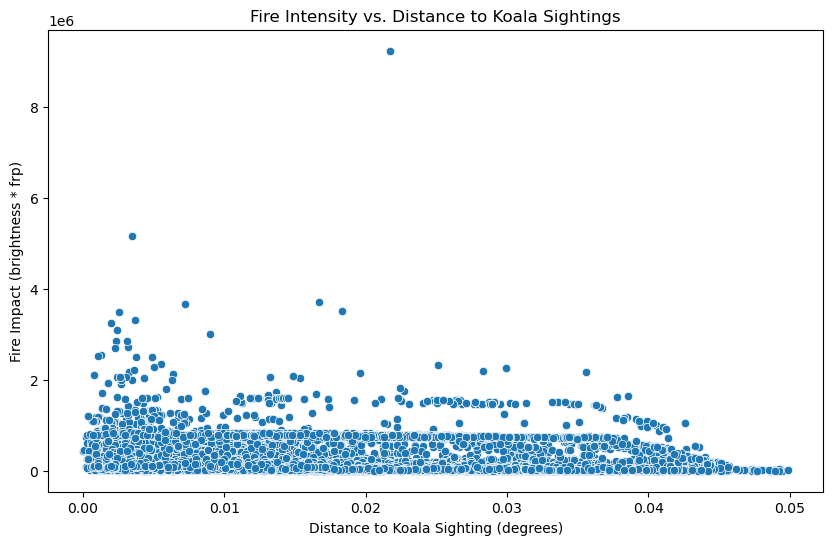

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="distance_to_koala", y="fire_impact", data=koalas_with_fire_impact.dropna(subset=["distance_to_koala", "fire_impact"]))
plt.title("Fire Intensity vs. Distance to Koala Sightings")
plt.xlabel("Distance to Koala Sighting (degrees)")
plt.ylabel("Fire Impact (brightness * frp)")
plt.show()

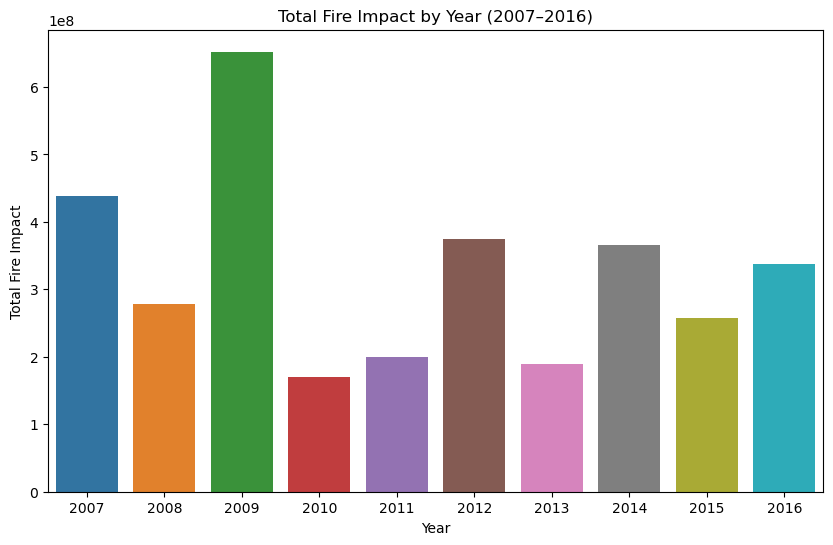

In [8]:

plt.figure(figsize=(10, 6))
fire_impact_by_year = fires_within_buffer.groupby(fires_within_buffer["acq_date"].dt.year)["fire_impact"].sum()
sns.barplot(x=fire_impact_by_year.index, y=fire_impact_by_year.values)
plt.title("Total Fire Impact by Year (2007–2016)")
plt.xlabel("Year")
plt.ylabel("Total Fire Impact")
plt.show()